In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [64]:
# 1. 데이터 로드 및 전처리
df = pd.read_csv('train.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

df['hour'] = df['datetime'].dt.hour
df = df.drop(columns=['datetime', 'atemp'])

In [65]:
# 이상치 확인용 박스플롯
# sns.boxplot(y='count', data=df)

# 이상치 제거 (선택사항, 극단값만 제거 예시)
q1 = df['count'].quantile(0.01)
q99 = df['count'].quantile(0.99)
df = df[(df['count'] >= q1) & (df['count'] <= q99)]

In [66]:
# Binning
temp_bins = pd.cut(df['temp'], bins=10, retbins=True)[1]
df['t_bin'] = pd.cut(df['temp'], bins=temp_bins, labels=False, include_lowest=True)

h_bins = pd.cut(df['humidity'], bins=10, retbins=True)[1]
df['h_bin'] = pd.cut(df['humidity'], bins=h_bins, labels=False, include_lowest=True)

w_bins = pd.cut(df['windspeed'], bins=10, retbins=True)[1]
df['w_bin'] = pd.cut(df['windspeed'], bins=w_bins, labels=False, include_lowest=True)

In [67]:
# 불필요한 열 제거
df = df.drop(columns=['casual', 'registered'])

In [68]:
# target 분리 및 로그 변환
y_target = df['count']
y_target_log = np.log1p(y_target)
X_features = df.drop(['count'], axis=1)

# day 변수 제거 (효과 미미할 수 있음)
X_features = X_features.drop(columns=['day'])

# One-Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'hour', 'holiday',
                                                     'workingday','season','weather',
                                                     't_bin','h_bin','w_bin'])

In [69]:
X_features_ohe

,temp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,month_5,...,w_bin_0,w_bin_1,w_bin_2,w_bin_3,w_bin_4,w_bin_5,w_bin_6,w_bin_7,w_bin_8,w_bin_9
0,9.84,81,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,9.02,80,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,9.02,80,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,9.84,75,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
6,9.02,80,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,50,26.0027,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
10882,14.76,57,15.0013,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
10883,13.94,61,15.0013,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
10884,13.94,61,6.0032,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 7470, number of used features: 78
[LightGBM] [Info] Start training from score 4.613978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

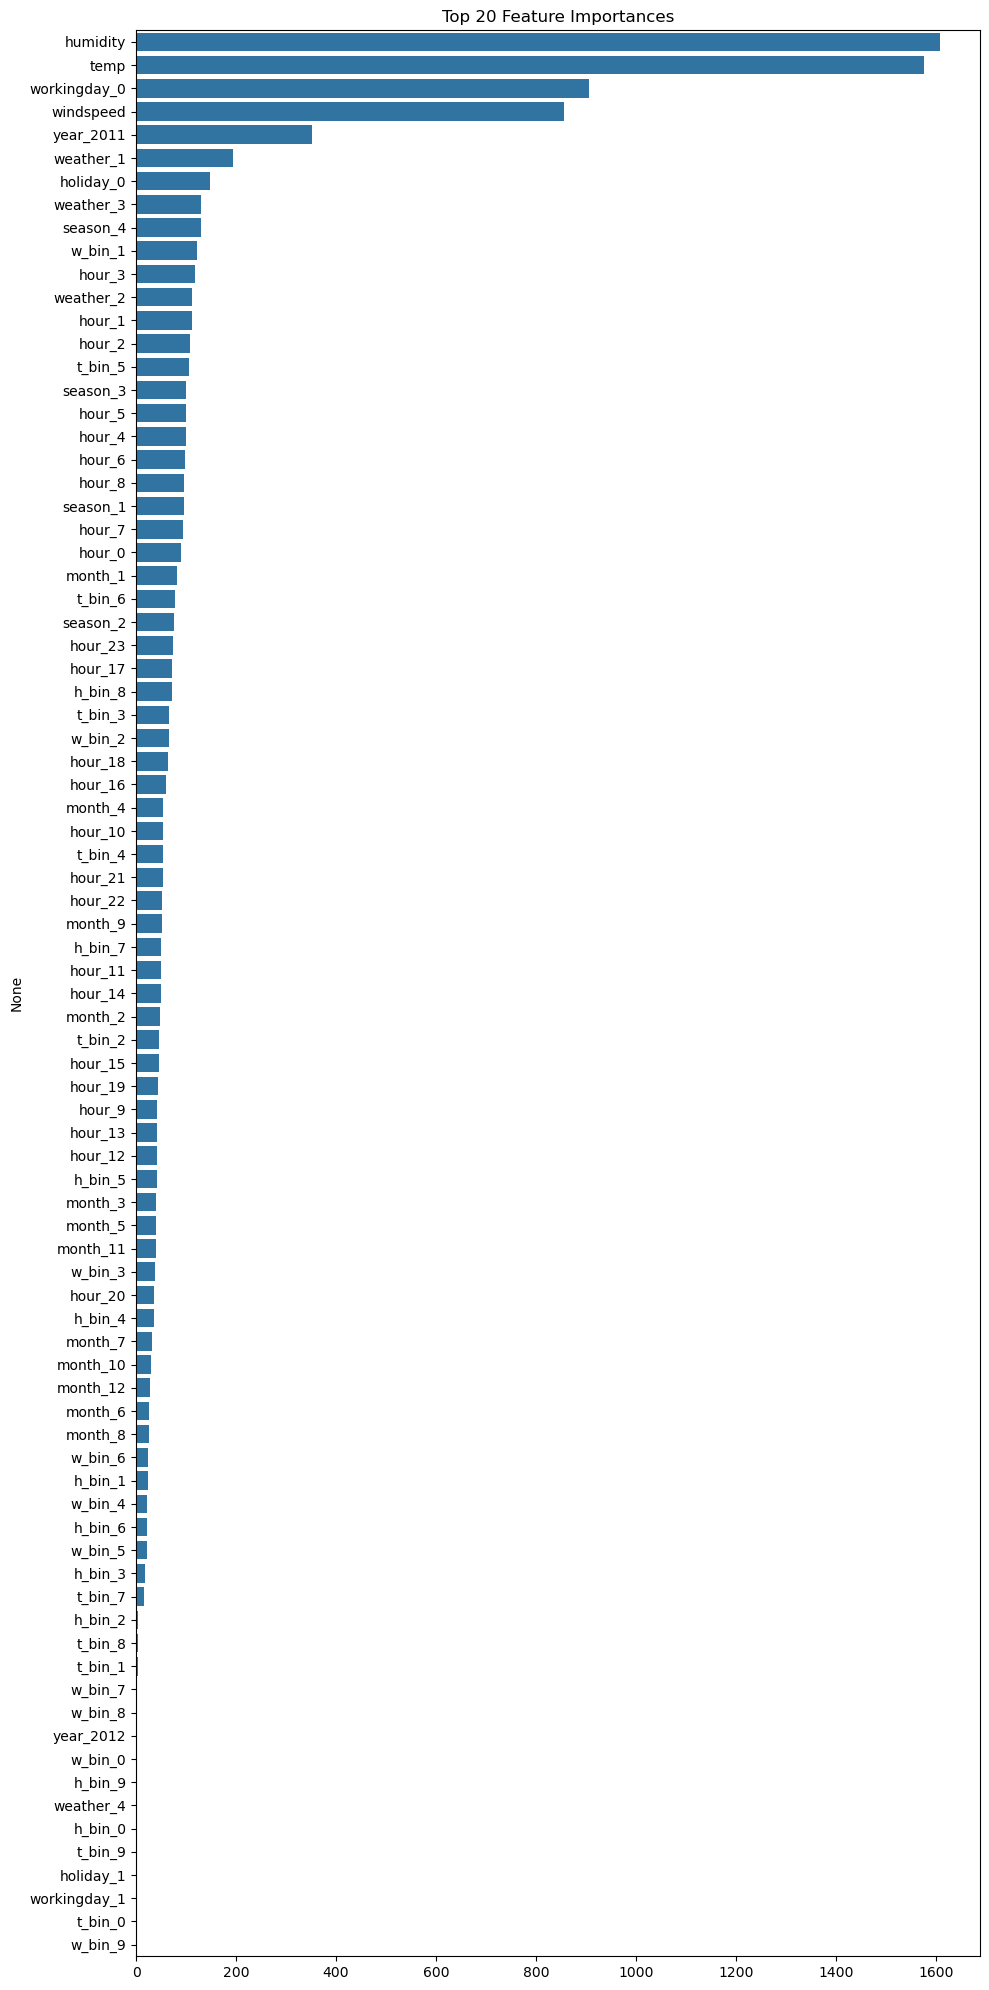

In [70]:
# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=42)

# 모델 학습
lgbm = LGBMRegressor(learning_rate=0.1, max_depth=6, min_child_samples=30, 
                     n_estimators=500, num_leaves=20)
lgbm.fit(X_train, y_train)

# 예측 및 평가
preds = lgbm.predict(X_test)
preds_exp = np.expm1(preds)
y_test_exp = np.expm1(y_test)

rmsle = np.sqrt(mean_squared_log_error(y_test_exp, preds_exp))
rmse = np.sqrt(mean_squared_error(y_test_exp, preds_exp))
mae = mean_absolute_error(y_test_exp, preds_exp)
print(f"RMSLE: {rmsle:.5f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

# 중요 피처 시각화
feature_imp = pd.Series(lgbm.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 20))
sns.barplot(x=feature_imp.values, y=feature_imp.index)
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [71]:
# ===== 테스트 데이터 처리 및 예측 =====
test_df = pd.read_csv('test.csv')
test_df['datetime'] = pd.to_datetime(test_df['datetime'])
test_df['year'] = test_df['datetime'].dt.year
test_df['month'] = test_df['datetime'].dt.month
test_df['day'] = test_df['datetime'].dt.day
test_df['hour'] = test_df['datetime'].dt.hour
test_df['t_bin'] = pd.cut(test_df['temp'], bins=temp_bins, labels=False, include_lowest=True)
test_df['h_bin'] = pd.cut(test_df['humidity'], bins=h_bins, labels=False, include_lowest=True)
test_df['w_bin'] = pd.cut(test_df['windspeed'], bins=w_bins, labels=False, include_lowest=True)

test_df = test_df.drop(columns=['atemp', 'day'])

# 피처 변환
X_t_features = test_df.drop(columns=['datetime'])
X_t_features_ohe = pd.get_dummies(X_t_features, columns=['year', 'month', 'hour', 'holiday',
                                                         'workingday','season','weather',
                                                         't_bin','h_bin','w_bin'])

In [72]:
X_t_features_ohe

,temp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,month_5,...,w_bin_0,w_bin_1,w_bin_2,w_bin_3,w_bin_4,w_bin_5,w_bin_6,w_bin_7,w_bin_8,w_bin_9
0,10.66,56,26.0027,True,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,10.66,56,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,10.66,56,0.0000,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,10.66,56,11.0014,True,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,10.66,56,11.0014,True,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,10.66,60,11.0014,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
6489,10.66,60,11.0014,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
6490,10.66,60,11.0014,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
6491,10.66,56,8.9981,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [73]:
missing_cols = set(X_train.columns) - set(X_t_features_ohe.columns)
print(missing_cols)

{'h_bin_0'}


In [74]:
# 누락된 열 보정
for col in missing_cols:
    X_t_features_ohe[col] = False
X_t_features_ohe = X_t_features_ohe[X_train.columns]  # 열 순서 정렬

# 예측 및 제출
final_preds = lgbm.predict(X_t_features_ohe)
final_preds = np.expm1(final_preds)
final_preds = np.maximum(final_preds, 0)

submission = pd.DataFrame({
    'datetime': test_df['datetime'],
    'count': final_preds
})
submission.to_csv('submission_final.csv', index=False)